
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome,
                           perform_experiments, ema_logging,Policy)

from ema_workbench import Samplers

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

from SALib.analyze import sobol

In [2]:
def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}



ema_logging.log_to_stderr(ema_logging.INFO)


uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)
                ] 


outcomes = [TimeSeriesOutcome('TIME'),
            TimeSeriesOutcome('predators'),
            TimeSeriesOutcome('prey')]


py_model = Model('Python', function=PredPrey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes

#### 1. Sensitivity analysis
Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using the statsmodel library and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment


In [3]:
n_exp = 1000

results_lhs = perform_experiments(py_model, scenarios=n_exp, uncertainty_sampling=Samplers.LHS)

exp_lhs, out_lhs = results_lhs

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [00:14<00:00, 68.55it/s]
[MainProcess/INFO] experiments finished


In [4]:
exp_lhs

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.000722,0.003303,0.046511,0.020861,0,None,Python
1,0.002493,0.003572,0.043307,0.027549,1,None,Python
2,0.002802,0.001963,0.049307,0.017224,2,None,Python
3,0.001316,0.003570,0.056567,0.024088,3,None,Python
4,0.002057,0.001195,0.071893,0.017120,4,None,Python
...,...,...,...,...,...,...,...
995,0.000800,0.002158,0.059312,0.015698,995,None,Python
996,0.000992,0.002464,0.053234,0.018194,996,None,Python
997,0.000782,0.002808,0.065800,0.020164,997,None,Python
998,0.001993,0.003154,0.047442,0.016230,998,None,Python


In [5]:
out_lhs['predators'].shape

(1000, 1, 1461)

For each of the sampling methods, we can then select outcomes of interest: the final values of the prey variable, the mean of the prey variable over time within each experiment, and the standard deviation of the same variable across time (again in each experiment).

In [6]:
prey_final_lhs = out_lhs['prey'][:,0,-1]
prey_final_lhs.shape

(1000,)

In [7]:
prey_final_lhs = out_lhs['prey'][:,0,-1]
prey_mean_lhs = np.mean(out_lhs['prey'][:,0,:],axis=1)
prey_std_lhs = np.std(out_lhs['prey'][:,0,:],axis=1)

As an example, we can first fit a linear regression model to the prey_final_lhs outcome. We first drop the 'model' and 'policy' columns from the experiments, which were not used in this example. The add_constant method can be used to add an intercept to the regression model.

In [8]:
import statsmodels.api as sm

X = pd.DataFrame(exp_lhs).drop(['model','policy'], inplace=False, axis=1)
X_0 = sm.add_constant(X)

est = sm.OLS(prey_final_lhs, X_0.astype(float)).fit()
print(est.summary())
print(est.params)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     129.2
Date:                Thu, 25 May 2023   Prob (F-statistic):          1.88e-105
Time:                        03:10:42   Log-Likelihood:                -4187.6
No. Observations:                1000   AIC:                             8387.
Df Residuals:                     994   BIC:                             8417.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  33.9213    

There is a lot of information provided here. The first one to look at is the R-squared. This is 0.423, so only 42% of the variance in model output is explained by this linear regression model. This suggests that there is close to 60% of the variance in model output is due to non-linear effects that a regression model cannot capture. Next, we look at the bottom part of the table. Looking at the `P>|t|` column, we see that only the predator efficiency and predator loss rate are statistically significant. These are, thus, parameters to which the model is sensitive.

#### 2. Sobol

In this case, the linear regression clearly isn't capturing most of the output variance (as shown by the R2 value). We can therefore use the Sobol results with the SALib analysis functions for a more comprehensive analysis. We first use the get_SALib_problem to convert the uncertainties we have previously defined, to a dictionary which is compatible with SALib. This includes the names and bounds of the uncertainties.

* Perform an appropriate number of experiments with the Sobol sampling functionality included in the Workbench, then analyze the results with SALib for the same three indicators. How can we interpret the first-order and total indices? Does your chosen sample size give a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function.

Note that the Sobol analysis will require N(2k+2) samples, where N is a baseline number of experiments required to cover the uncertainties (let's also assume 1000 in this case) and k is the number of uncertainties. We have k = 4 uncertainties, so we'll have 1000 * (8 + 2) = 10,000 experiments in total. We can choose the sampling by specifying the uncertainty_sampling argument; note that the Sobol sampler automatically adjusts the number of experiments based on the number of uncertainties and the specified value of N.

In [9]:
problem = get_SALib_problem(uncertainties)
print(problem)

{'num_vars': 4, 'names': ['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate'], 'bounds': [(0.0005, 0.003), (0.001, 0.004), (0.04, 0.08), (0.015, 0.035)]}


We can then pass the problem and the outcome values (using the results with the Sobol sample, instead of the LHS sample) to the SALib analysis function. By default, the Sobol sampler calculates second-order interaction effects between each pair of variables.

In [10]:
n_exp = 1000

experiments_sobol, outcomes_sobol = perform_experiments(py_model, scenarios=n_exp,
                                                        uncertainty_sampling=Samplers.SOBOL)

prey_final_sobol = outcomes_sobol['prey'][:,0,-1]
prey_mean_sobol = np.mean(outcomes_sobol['prey'][:,0,:],axis=1)
prey_std_sobol = np.std(outcomes_sobol['prey'][:,0,:],axis=1)

Si = sobol.analyze(problem, prey_mean_sobol, calc_second_order=True, print_to_console=True) #WHY hier niet xperiments_sobol als eerste input paramter, maar problem?

C:\Users\thoma\Anaconda3\envs\model_based_decision_making\Lib\site-packages\scipy\stats\_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
100%|████████████████████████████████████| 10000/10000 [02:31<00:00, 66.11it/s]
[MainProcess/INFO] experiments finished


                           ST   ST_conf
predation_rate       0.005101  0.000833
predator_efficiency  0.818984  0.064357
predator_loss_rate   0.220395  0.027616
prey_birth_rate      0.010972  0.001467
                           S1   S1_conf
predation_rate       0.001047  0.007071
predator_efficiency  0.778730  0.077832
predator_loss_rate   0.177754  0.037387
prey_birth_rate      0.001531  0.008240
                                                 S2   S2_conf
(predation_rate, predator_efficiency)     -0.002769  0.013388
(predation_rate, predator_loss_rate)      -0.000141  0.011662
(predation_rate, prey_birth_rate)          0.000386  0.010858
(predator_efficiency, predator_loss_rate)  0.022902  0.124771
(predator_efficiency, prey_birth_rate)    -0.005554  0.105829
(predator_loss_rate, prey_birth_rate)     -0.000421  0.061864


The 40% needs to be 77%?!

The SALib analysis returns a dictionary with keys for the different relevant indicators (e.g. S1 and ST for first-order and total effects). The values are in the same order as the names of the problem dictionary, and indicate the fraction of total output variance corresponding to each of the indices (so that, for example, the predator_efficiency variable contributes approximately 40% of variance on its own, or over 80% when including interactions with other inputs). We can quickly visualize the first-order and total effects as well as their confidence intervals, by converting the results to a DataFrame:

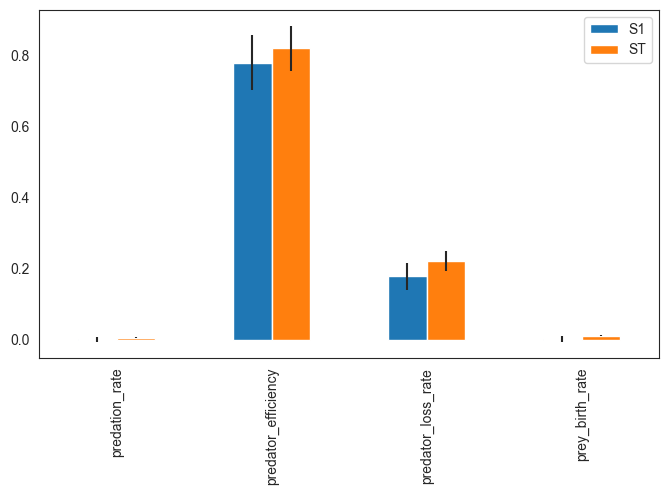

In [11]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

The figure shows the total order effects (ST) in orange and the first order effects (s1) in blue. The black line indicates the error bar around the estimated effect. In line with the regression results, we see that predator efficiency and predator loss rate are the two dominant parameters to which the model is sensitive. The relatively small differences between the first-order effects and total-order effects (i.e., blue and orange bars) suggest that most of the sensitivity is due to direct effects rather than due to interaction effects.

We can also study the convergence of the Sobol indices as a function of the number of samples, by computing the indices over a partial sample:

How is the error term determined and why is that one there? The variance kan be calculated exactly right, so why the black estimated errors? Because not all the data is sampled?

In [12]:
Y = prey_mean_sobol

s_data = pd.DataFrame(index=problem['names'],
                      columns=np.arange(20,n_exp,50)*(2*problem['num_vars']+2))
for j in s_data.columns:
    scores = sobol.analyze(problem, Y[0:j], calc_second_order=True, print_to_console=False)
    s_data.loc[:,j] = scores['ST']

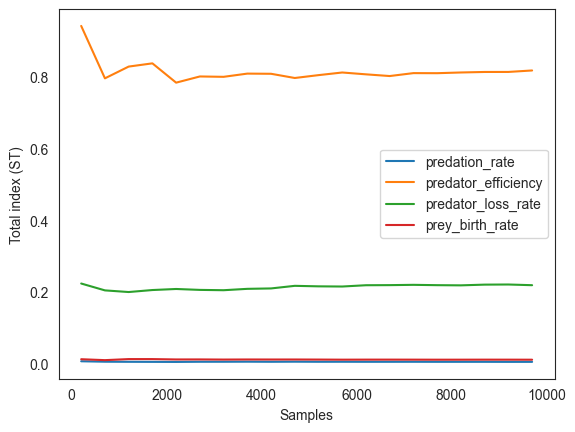

In [13]:
fig, ax = plt.subplots(1)

s_data.T.plot(ax=ax)
ax.set_xlabel('Samples')
ax.set_ylabel('Total index (ST)')
plt.show()

The figure shows the estimate of the total order effect for all parameters as a function of the number of samples. The estimates converge relatively quickly because they become essentially stable after 4000 samples.

#### 4. Extra trees
Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices?

In [14]:
from ema_workbench.analysis import feature_scoring

In this step, the Extra-Trees analysis is performed to approximate the Sobol total indices. The analysis aims to assess the importance of input parameters on the model output, considering their interactions. The Extra-Trees method is an efficient alternative to the more computationally expensive Sobol indices.

In [15]:
prey_final_sobol = outcomes_sobol['prey'][:,0,-1]
prey_mean_sobol = np.mean(outcomes_sobol['prey'][:,0,:],axis=1)
prey_std_sobol = np.std(outcomes_sobol['prey'][:,0,:],axis=1)

In [16]:
scores = feature_scoring.get_ex_feature_scores(experiments_sobol, prey_final_sobol,
                                      max_features=0.6, mode=RuleInductionType.REGRESSION)[0]
scores

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


,1
0,
predator_efficiency,0.520800
predator_loss_rate,0.220001
prey_birth_rate,0.208405
predation_rate,0.050793


In [17]:
combined_scores = []
for j in range(100, experiments_sobol.shape[0], 100):
    scores = feature_scoring.get_ex_feature_scores(experiments_sobol.iloc[0:j, :],
                                                   prey_mean_sobol[0:j],
                                                   max_features=0.6,
                                                   mode=RuleInductionType.REGRESSION)[0]
    scores.columns = [j]
    combined_scores.append(scores)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

In [18]:
combined_scores = pd.concat(combined_scores, axis=1, sort=True)

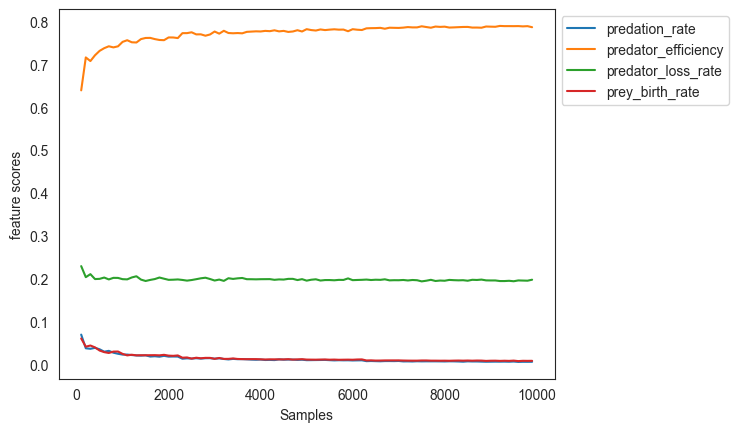

In [19]:
fig, ax = plt.subplots(1)

combined_scores.T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Samples')
ax.set_ylabel('feature scores')
plt.show()

This figure is similar to the convergence analysis for Sobol and here to we see convergence after roughly 4000 samples

#### Concluding remarks
This assignment has shown how to perform global sensitivity analysis using linear regression, Sobol, and extra-trees feature scoring. Of these three, Sobol and extra trees are the preferred methods because of their ability to deal with nonlinear effects. Sobol is the gold standard, but requires a very large number of computational experiments. Extra trees is often a convenient alternative that requires fever runs for comparable results.